In [1]:
import gym
from gym.envs.toy_text.frozen_lake import generate_random_map, FrozenLakeEnv
#from mdptoolbox.mdp import ValueIteration, PolicyIteration, QLearning
from hiive.mdptoolbox.mdp import ValueIteration, PolicyIteration, QLearning
from timeit import default_timer as timer
from datetime import timedelta
import random
from collections import deque
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import time

In [2]:
# -*- coding: utf-8 -*-
import gym
import re
import numpy as np
class OpenAI_MDPToolbox:

    """Class to convert Discrete Open AI Gym environemnts to MDPToolBox environments. 
    You can find the list of available gym environments here: https://gym.openai.com/envs/#classic_control
    You'll have to look at the source code of the environments for available kwargs; as it is not well documented.  
    """
    
    def __init__(self, openAI_env, render:bool=False, **kwargs):
        """Create a new instance of the OpenAI_MDPToolbox class
        :param openAI_env_name: Valid name of an Open AI Gym env 
        :type openAI_env_name: str
        :param render: whether to render the Open AI gym env
        :type rander: boolean 
        """
        #self.env_name = openAI_env_name
    
        self.env = openAI_env
        self.env.reset()

        if render:
            self.env.render()
        
        self.transitions = self.env.P
        self.actions = int(re.findall(r'\d+', str(self.env.action_space))[0])
        self.states = int(re.findall(r'\d+', str(self.env.observation_space))[0])
        self.P = np.zeros((self.actions, self.states, self.states))
        self.R = np.zeros((self.states, self.actions))
        self.convert_PR()
        
    def convert_PR(self):
        """Converts the transition probabilities provided by env.P to MDPToolbox-compatible P and R arrays
        """
        for state in range(self.states):
            for action in range(self.actions):
                for i in range(len(self.transitions[state][action])):
                    tran_prob = self.transitions[state][action][i][0]
                    state_ = self.transitions[state][action][i][1]
                    self.R[state][action] += tran_prob*self.transitions[state][action][i][2]
                    self.P[action, state, state_] += tran_prob

In [3]:
from gym.envs.toy_text.frozen_lake import generate_random_map, FrozenLakeEnv
np.random.seed(2)
tvelve = generate_random_map(12)
sixteen = generate_random_map(16)

MAPS = {
    "4x4": ["SFFF", "FHFH", "FFFH", "HFFG"],
    "8x8": [
        "SFFFFFFF",
        "FFFFFFFF",
        "FFFHFFFF",
        "FFFFFHFF",
        "FFFHFFFF",
        "FHHFFFHF",
        "FHFFHFHF",
        "FFFHFFFG",
    ],
    "12x12": tvelve,
    "16x16": sixteen
}

In [4]:
def test_policy(env, policy, n_epoch=10000):
    rewards = []
    episode_counts = []
    for i in range(n_epoch):
        current_state = env.reset()
        episode = 0
        done = False
        episode_reward = 0
        while not done:
            episode += 1
            act = int(policy[current_state])
            new_state, reward, done, _ = env.step(act)
            episode_reward += reward
            current_state = new_state
            
        rewards.append(episode_reward)
        episode_counts.append(episode)
    
    mean_reward = sum(rewards)/len(rewards)
    mean_eps = sum(episode_counts)/len(episode_counts)
    return mean_reward, mean_eps, rewards, episode_counts 

In [5]:
def transform_map(the_map):
    size = len(the_map)
    dis_map = np.zeros((size,size))
    for i, row in enumerate(the_map):
        for j, loc in enumerate(row):
            if loc == "S":
                dis_map[i, j] = 0
            elif loc == "F":
                dis_map[i, j] = 0
            elif loc == "H":
                dis_map[i, j] = -1
            elif loc == "G":
                dis_map[i, j] = 1
    return dis_map


def np_policy(policy):
    size = int(np.sqrt(len(policy)))
    pol = np.asarray(policy)
    pol = pol.reshape((size, size))
    return pol


def plot_policy(map_size, policy):
    map_name = str(map_size)+"x"+str(map_size)
    data = transform_map(MAPS[map_name])
    np_pol = np_policy(policy)
    plt.imshow(data, interpolation="nearest")

    for i in range(np_pol[0].size):
        for j in range(np_pol[0].size):
            arrow = '\u2190'
            if np_pol[i, j] == 1:
                arrow = '\u2193'
            elif np_pol[i, j] == 2:
                arrow = '\u2192'
            elif np_pol[i, j] == 3:
                arrow = '\u2191'
            text = plt.text(j, i, arrow,
                           ha="center", va="center", color="w")
    plt.axis('off')
    plt.show()


In [6]:
import numpy as np
import matplotlib.pyplot as plt

def plot_values(V, shape):
    # reshape value function
    V_sq = np.reshape(V, shape)

    # plot the state-value function
    fig = plt.figure(figsize=shape)
    ax = fig.add_subplot(111)
    im = ax.imshow(V_sq, cmap='cool')
    for (j,i),label in np.ndenumerate(V_sq):
        ax.text(i, j, np.round(label, 5), ha='center', va='center', fontsize=14)
    plt.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    plt.title('State-Value Function')
    plt.show()

In [7]:
def value_iteration(tb_env, gamma=.99, eps=.001):
    vi = ValueIteration(tb_env.P, tb_env.R, gamma, epsilon=eps)
    vi.run()
    return vi

In [8]:
def policy_iteration(tb_env, gamma=.99):
    pi = PolicyIteration(tb_env.P, tb_env.R, gamma, eval_type=1,)
    pi.run()
    return pi

In [9]:
def train_and_test_vi(toolbox_env, discount_factors=[0.9], epsilons=[1e-9]):
    vi_dict = {}
    for dis in discount_factors:
        vi_dict[dis] = {}
        for eps in epsilons:
            vi_dict[dis][eps] = {}
            vi = value_iteration(toolbox_env, dis, eps)
            mean_reward, mean_eps, rewards, episode_counts  = test_policy(toolbox_env.env, vi.policy)    
            vi_dict[dis][eps]["mean_reward"] = mean_reward
            vi_dict[dis][eps]["mean_eps"] = mean_eps
            vi_dict[dis][eps]["iteration"] = vi.iter
            vi_dict[dis][eps]["time_spent"] = vi.time
            vi_dict[dis][eps]["policy"] = vi.policy
    return vi_dict

In [10]:
def train_and_test_pi(toolbox_env, discount_factors=[0.9]):
    pi_dict = {}
    for dis in discount_factors:
        pi_dict[dis] = {}
        pi = policy_iteration(toolbox_env, dis)
        mean_reward, mean_eps, rewards, episode_counts  = test_policy(toolbox_env.env, pi.policy)    
        pi_dict[dis]["mean_reward"] = mean_reward
        pi_dict[dis]["mean_eps"] = mean_eps
        pi_dict[dis]["iteration"] = pi.iter
        pi_dict[dis]["time_spent"] = pi.time
        pi_dict[dis]["policy"] = pi.policy
    return pi_dict

# 4x4 Frozen Lake

# Value Iteration

In [30]:
env = gym.make('FrozenLake-v1', desc=MAPS["4x4"], is_slippery=True)
env.render()
toolbox_env = OpenAI_MDPToolbox(env)
discount_factors = np.linspace(0.5, 0.99, num=10)
epsilons=[1e-3, 1e-6, 1e-9, 1e-12, 1e-15]
vi_dict = train_and_test_vi(toolbox_env,discount_factors, epsilons)


SFFF
FHFH
FFFH
HFFG


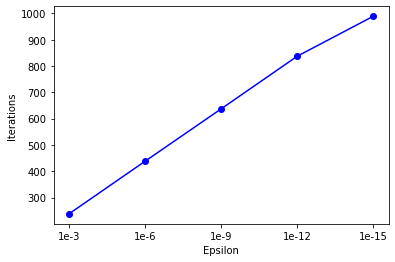

In [19]:
iteration_eps_3=[vi_dict[disc][1e-3]['iteration'] for disc in vi_dict]
iteration_eps_6=[vi_dict[disc][1e-6]['iteration'] for disc in vi_dict]
iteration_eps_9=[vi_dict[disc][1e-9]['iteration'] for disc in vi_dict]
iteration_eps_12=[vi_dict[disc][1e-12]['iteration'] for disc in vi_dict]
iteration_eps_15=[vi_dict[disc][1e-15]['iteration'] for disc in vi_dict]
iterations=[max(iteration_eps_3),max(iteration_eps_6),max(iteration_eps_9),max(iteration_eps_12),max(iteration_eps_15)]
epsilons=['1e-3','1e-6','1e-9','1e-12','1e-15']
plt.plot(epsilons, iterations, color='b', marker='o')
plt.xlabel('Epsilon')
plt.ylabel('Iterations')
plt.show()

In [58]:
def train_different_vi_gamma():
    discount_factors = np.linspace(0.5, 0.9999, num=5)
    scores_gamma = {}
    for gamma in discount_factors:
        env = gym.make('FrozenLake-v1', desc=MAPS["4x4"], is_slippery=True)
        toolbox_env = OpenAI_MDPToolbox(env)
        print("discount factor: {:.6f}\n".format(gamma), end="")
        vi = value_iteration(toolbox_env, gamma, 1e-15)
        mean_reward, mean_eps, rewards, episode_counts  = test_policy(toolbox_env.env, vi.policy)  
        scores_gamma[gamma] = rewards
    return scores_gamma

In [59]:
scores_gamma=train_different_vi_gamma()

discount factor: 0.500000
discount factor: 0.624975
discount factor: 0.749950
discount factor: 0.874925
discount factor: 0.999900


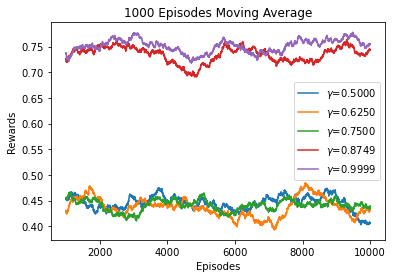

In [62]:
plot_scores_2_discount_factor_vi_pi(scores_gamma)

In [77]:
def plot_scores_2_discount_factor_vi_pi(scores_gamma):
    scores_discount_factor_pd = None
    for discount in np.linspace(0.5, 0.9999, num=5):
        df = pd.DataFrame(pd.Series(list(scores_gamma[discount])).rolling(1000).mean(),
                          columns=[r"$\gamma$=" + '{:.4f}'.format(discount)])
        scores_discount_factor_pd = pd.concat([scores_discount_factor_pd, df], axis=1)
    scores_discount_factor_pd = scores_discount_factor_pd.fillna(method='ffill')
    scores_discount_factor_pd['Episodes'] = np.arange(scores_discount_factor_pd.shape[0])
    ax = plt.gca()
    ax.set_title('1000 Episodes Moving Average')
    plt.ylabel("Rewards")
    scores_discount_factor_pd.plot(kind='line', x='Episodes', y=scores_discount_factor_pd.columns[0], ax=ax)
    scores_discount_factor_pd.plot(kind='line', x='Episodes', y=scores_discount_factor_pd.columns[1], ax=ax)
    scores_discount_factor_pd.plot(kind='line', x='Episodes', y=scores_discount_factor_pd.columns[2], ax=ax)
    scores_discount_factor_pd.plot(kind='line', x='Episodes', y=scores_discount_factor_pd.columns[3], ax=ax)
    scores_discount_factor_pd.plot(kind='line', x='Episodes', y=scores_discount_factor_pd.columns[4], ax=ax)
    plt.show()

0.12202286720275879


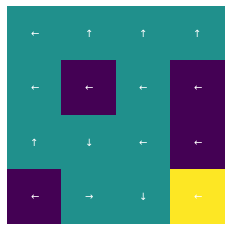

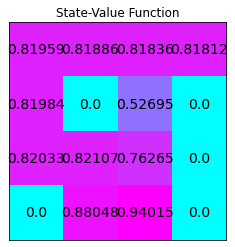

In [13]:
env = gym.make('FrozenLake-v1', desc=MAPS["4x4"], is_slippery=True)
toolbox_env = OpenAI_MDPToolbox(env)
start = time.time()
vi = value_iteration(toolbox_env,  gamma=0.9999, eps=1e-15)
elapsed_time = time.time() - start
print(elapsed_time)
plot_policy(4, vi.policy)
plot_values(vi.V, (4,4))

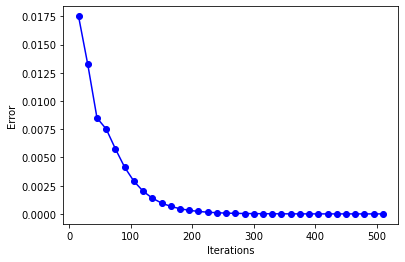

In [71]:
iterations= [stat['Iteration'] for stat in vi.run_stats]
error= [stat['Error'] for stat in vi.run_stats]
plt.plot(iterations,error, color='b', marker='o')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.show()

# Policy Iteration

In [29]:
env = gym.make('FrozenLake-v1', desc=MAPS["4x4"], is_slippery=True)
#env.render()
toolbox_env = OpenAI_MDPToolbox(env)
discount_factors = np.linspace(0.5, 0.99, num=10)
pi_dict = train_and_test_pi(toolbox_env,discount_factors)

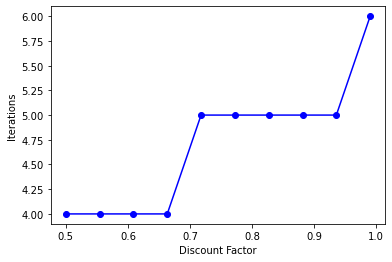

In [33]:
iterations=[pi_dict[disc]['iteration'] for disc in pi_dict]
plt.plot(discount_factors, iterations, color='b', marker='o')
plt.xlabel('Discount Factor')
plt.ylabel('Iterations')
plt.show()

In [75]:
def train_different_pi_gamma():
    discount_factors = np.linspace(0.5, 0.9999, num=5)
    scores_gamma = {}
    for gamma in discount_factors:
        env = gym.make('FrozenLake-v1', desc=MAPS["4x4"], is_slippery=True)
        toolbox_env = OpenAI_MDPToolbox(env)
        print("discount factor: {:.6f}\n".format(gamma), end="")
        pi = policy_iteration(toolbox_env, gamma)
        mean_reward, mean_eps, rewards, episode_counts  = test_policy(toolbox_env.env, pi.policy)  
        scores_gamma[gamma] = rewards
    return scores_gamma

In [76]:
scores_gamma=train_different_pi_gamma()

discount factor: 0.500000
discount factor: 0.624975
discount factor: 0.749950
discount factor: 0.874925
discount factor: 0.999900


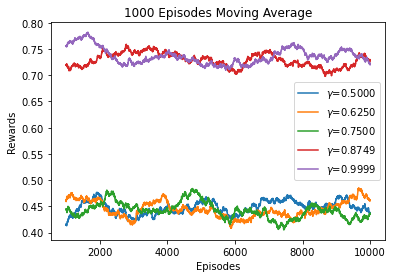

In [78]:
plot_scores_2_discount_factor_vi_pi(scores_gamma)

0.027616024017333984


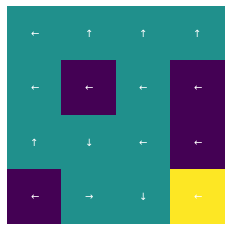

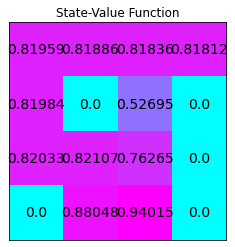

In [14]:
env = gym.make('FrozenLake-v1', desc=MAPS["4x4"], is_slippery=True)
toolbox_env = OpenAI_MDPToolbox(env)
start = time.time()
pi = policy_iteration(toolbox_env,  gamma=0.9999)
elapsed_time = time.time() - start
print(elapsed_time)
plot_policy(4, pi.policy)
plot_values(pi.V, (4,4))

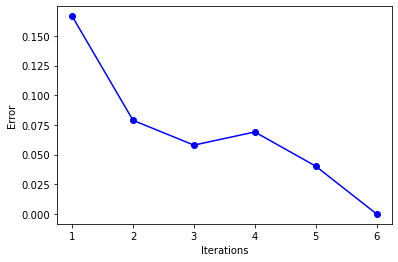

In [15]:
iterations= [stat['Iteration'] for stat in pi.run_stats]
error= [stat['Error'] for stat in pi.run_stats]
plt.plot(iterations,error, color='b', marker='o')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.show()

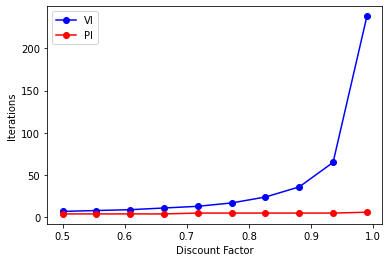

In [37]:
vi_iters=[vi_dict[disc][1e-15]['iteration']for disc in vi_dict]
pi_iters=[pi_dict[disc]['iteration'] for disc in pi_dict]
plt.plot(discount_factors, vi_iters, label='VI', color='b', marker='o')
plt.plot(discount_factors, pi_iters, label='PI', color='r', marker='o')
plt.xlabel('Discount Factor')
plt.ylabel('Iterations')
plt.legend(loc=0)
plt.show()

In [28]:
vi_time_spent=[vi_dict[disc][1e-3]['time_spent']/vi_dict[disc][1e-3]['iteration']for disc in vi_dict]
pi_time_spent=[pi_dict[disc]['time_spent']/pi_dict[disc]['iteration'] for disc in pi_dict]
plt.plot(discount_factors, vi_time_spent, label='VI', color='b', marker='o')
plt.plot(discount_factors, pi_time_spent, label='PI', color='r', marker='o')
plt.xlabel('Discount Factor')
plt.ylabel('Time/Iteration')
plt.legend(loc=0)
plt.show()

NameError: name 'vi_dict' is not defined

# Q-Learning

In [18]:
def q_learning_f_lake_env(env, total_episodes=100000, discount=0.99,  alpha=0.01, decay_rate=1e-03):
    number_of_states = env.observation_space.n
    number_of_actions = env.action_space.n
    qtable = np.zeros((number_of_states, number_of_actions))
    learning_rate = alpha
    gamma = discount

    # exploration parameter
    epsilon = 1.0
    max_epsilon = 1.0
    min_epsilon = 0.01
    rewards = []
    reward_window = deque(maxlen=10000)
    start = time.time()
    for episode in range(int(total_episodes)):
        # reset the environment
        state = env.reset()
        step = 0
        done = False
        total_reward = 0
        while True:
            if random.uniform(0,1) < epsilon:
                action = env.action_space.sample()
            else:
                #b = qtable[state, :]
                #action = np.random.choice(np.where(b == b.max())[0])
                action = np.argmax(qtable[state, :])
          

            new_state, reward, done, info = env.step(action)
            total_reward += reward
            # update Q(s,a) := Q(s,a) + lr [R(s,a) + gamma * max(Q (s', a') - Q(s,a))]
            if not done:
                qtable[state, action] = qtable[state, action] + learning_rate*(reward + gamma*np.max(qtable[new_state, :]) - qtable[state, action])
            else:
                qtable[state, action] = qtable[state,action] + learning_rate*(reward - qtable[state,action])

            state = new_state
            if done:
                break
                
        # reduce epsilon 
        rewards.append(total_reward)
        reward_window.append(total_reward)

        #epsilon = max(max_epsilon -  decay_rate * episode, min_epsilon) 
        epsilon = epsilon_func(episode) 
        if episode % 10000 == 0:     
            print('\rEpisode {:d} \tAverage Score: {:.2f}'.format(episode, np.mean(reward_window)))
    
    elapsed_time = time.time() - start
    print("Solved in: {} episodes and {} seconds".format(total_episodes, elapsed_time))
    return np.argmax(qtable, axis=1), total_episodes, elapsed_time, qtable, rewards

In [14]:
import math
A=0.5
B=0.1
C=0.2
EPISODES=100000
def epsilon_func(time):
    standardized_time=(time-A*EPISODES)/(B*EPISODES)
    cosh=np.cosh(math.exp(-standardized_time))
    epsilon=1.1-(1/cosh+(time*C/EPISODES))
    return epsilon

Text(0.5, 1.0, 'Decay Function')

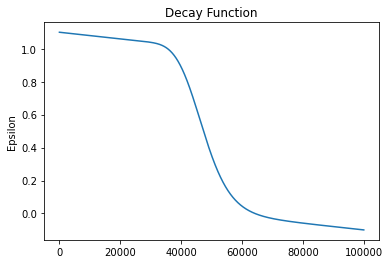

In [15]:
episodes = list(range(0, EPISODES))
epsilons =[epsilon_func(episode) for episode in episodes]
plt.plot(episodes,epsilons)
plt.ylabel('Epsilon')
plt.title('Decay Function')

In [21]:
env = gym.make('FrozenLake-v1', desc=MAPS["4x4"], is_slippery=True)
env.render()
q_policy, q_solve_iter, q_solve_time, q_table, rewards = q_learning_f_lake_env(env, discount=0.99, alpha=0.1, decay_rate=1e-4)


SFFF
FHFH
FFFH
HFFG
Episode 0 	Average Score: 0.00
Episode 10000 	Average Score: 0.01
Episode 20000 	Average Score: 0.01
Episode 30000 	Average Score: 0.01
Episode 40000 	Average Score: 0.02
Episode 50000 	Average Score: 0.05
Episode 60000 	Average Score: 0.30
Episode 70000 	Average Score: 0.69
Episode 80000 	Average Score: 0.75
Episode 90000 	Average Score: 0.74
Solved in: 100000 episodes and 167.420752286911 seconds


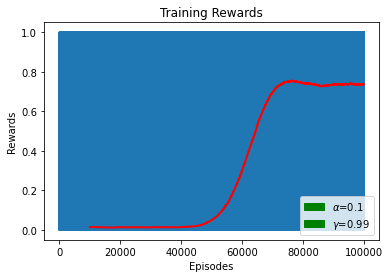

In [215]:
plot_training_graphs(rewards)

0.82


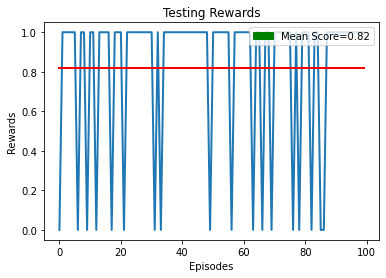

In [261]:
env = gym.make('FrozenLake-v1', desc=MAPS["4x4"], is_slippery=True)
mean_reward, mean_eps, test_rewards, episode_counts = test_policy(env , q_policy, n_epoch=100)
print(mean_reward)
plot_testing_graphs(test_rewards)

In [22]:
def plot_training_graphs(train_scores, discount=0.99, alpha=0.1, decay_rate=1e-4):
    lr_patch = mpatches.Patch(label=r"$\alpha$=" + str(alpha), color='green')
    gamma_patch = mpatches.Patch(label=r"$\gamma$=" + str(discount), color='green')
    #epsilon_decay_patch = mpatches.Patch(label='epsilon_decay=' + str(decay_rate), color='green')
    scores_df = pd.DataFrame(train_scores)
    scores_df['rolling_mean'] = scores_df[scores_df.columns[0]].rolling(10000).mean()
    scores_df['Episodes'] = np.arange(scores_df.shape[0])
    ax = plt.gca()
    ax.set_title('Training Rewards')
    plt.ylabel("Rewards")
    colors = ['tab:blue', 'red']
    scores_df.plot(color=colors, kind='line', x='Episodes', linewidth=2, ax=ax)
    plt.legend(handles=[lr_patch, gamma_patch],loc='lower right')
    plt.show()

In [23]:
def plot_testing_graphs(test_scores):
    mean_score = mpatches.Patch(label="Mean Score=" + "{:.6f}".format(np.mean(test_scores)), color='green')
    scores_df = pd.DataFrame(test_scores)
    scores_df['rolling_mean'] = scores_df[scores_df.columns[0]].mean()
    scores_df['Episodes'] = np.arange(scores_df.shape[0])
    ax = plt.gca()
    ax.set_title('Testing Rewards')
    plt.ylabel("Rewards")
    colors = ['tab:blue', 'red']
    scores_df.plot(color=colors, kind='line', x='Episodes', linewidth=2, ax=ax)
    plt.legend(handles=[mean_score], loc='upper right')
    plt.show()

# Reward Shaping

In [263]:
env = gym.make('FrozenLake-v1', desc=MAPS["4x4"], is_slippery=True)
q_policy, q_solve_iter, q_solve_time, q_table, rewards = q_learning_f_lake_env(env)

Episode 0 	Average Score: 0.00
Episode 10000 	Average Score: 0.06
Episode 20000 	Average Score: 0.06
Episode 30000 	Average Score: 0.07
Episode 40000 	Average Score: 0.13
Episode 50000 	Average Score: 0.22
Episode 60000 	Average Score: 0.21
Episode 70000 	Average Score: 0.21
Episode 80000 	Average Score: 0.21
Episode 90000 	Average Score: 0.21
Solved in: 100000 episodes and 0:00:33.943758 seconds


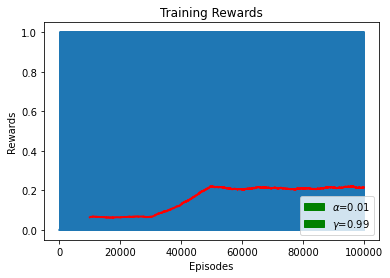

In [264]:
plot_training_graphs(rewards,discount=0.99, alpha=0.01, decay_rate=1e-4)

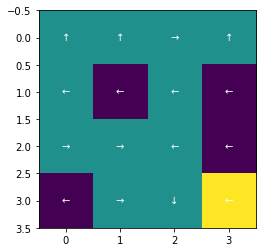

In [265]:
plot_policy(4, q_policy)

In [266]:
env = gym.make('FrozenLake-v1', desc=MAPS["4x4"], is_slippery=True)
actions= int(re.findall(r'\d+', str(env.action_space))[0])
states= int(re.findall(r'\d+', str(env.observation_space))[0])
for state in range(states):
    for action in range(actions):
        possible_actions = env.P[state][action]
        for i in range(len(possible_actions)):
            if possible_actions[i][3]== True and possible_actions[i][1]!=15:
                y = list(possible_actions[i])
                #print(y)
                y[2] = -1.0
                x = tuple(y)
                #print(x)
                env.P[state][action][i] = x
            if possible_actions[i][3]== True and possible_actions[i][1]==15 and state!=15:
                y = list(possible_actions[i])
                #print(y)
                y[2] = 2.0
                x = tuple(y)
                #print(x)
                env.P[state][action][i] = x
            
env.render()   



SFFF
FHFH
FFFH
HFFG


In [267]:
q_policy, q_solve_iter, q_solve_time, q_table, rewards = q_learning_f_lake_env(env)

Episode 0 	Average Score: -1.00
Episode 10000 	Average Score: 0.79
Episode 20000 	Average Score: 0.94
Episode 30000 	Average Score: 0.96
Episode 40000 	Average Score: 1.02
Episode 50000 	Average Score: 1.17
Episode 60000 	Average Score: 1.18
Episode 70000 	Average Score: 1.18
Episode 80000 	Average Score: 1.17
Episode 90000 	Average Score: 1.17
Solved in: 100000 episodes and 0:01:25.756955 seconds


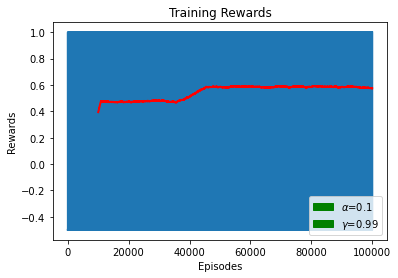

In [268]:
rewards = [x / 2.0 for x in rewards]
plot_training_graphs(rewards)

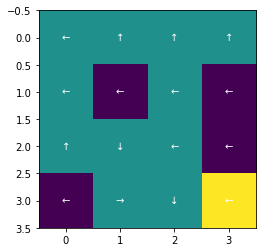

In [269]:
plot_policy(4, q_policy)

In [193]:
def train_different_discount_rate(env):
    scores_gamma = {}
    for gamma in np.linspace(0.5, 0.99, num=5):
        print("discount rate: {:.3f}\n".format(gamma), end="")
        scores_gamma[gamma] = q_learning_f_lake_env(env, discount=gamma)
    pickle.dump(scores_gamma, open("results_fl_4/scores_gamma.p", "wb"))

In [194]:
env = gym.make('FrozenLake-v1', desc=MAPS["4x4"], is_slippery=True)
train_different_discount_rate(env)

discount rate: 0.500
Episode 0 	Average Score: 0.00
Episode 10000 	Average Score: 0.01
Episode 20000 	Average Score: 0.01
Episode 30000 	Average Score: 0.01
Episode 40000 	Average Score: 0.02
Episode 50000 	Average Score: 0.03
Episode 60000 	Average Score: 0.11
Episode 70000 	Average Score: 0.20
Episode 80000 	Average Score: 0.36
Episode 90000 	Average Score: 0.39
Solved in: 100000 episodes and 0:00:27.623513 seconds
discount rate: 0.623
Episode 0 	Average Score: 0.00
Episode 10000 	Average Score: 0.02
Episode 20000 	Average Score: 0.01
Episode 30000 	Average Score: 0.01
Episode 40000 	Average Score: 0.02
Episode 50000 	Average Score: 0.04
Episode 60000 	Average Score: 0.15
Episode 70000 	Average Score: 0.30
Episode 80000 	Average Score: 0.42
Episode 90000 	Average Score: 0.31
Solved in: 100000 episodes and 0:00:33.480038 seconds
discount rate: 0.745
Episode 0 	Average Score: 0.00
Episode 10000 	Average Score: 0.01
Episode 20000 	Average Score: 0.01
Episode 30000 	Average Score: 0.01
E

In [13]:
def plot_scores_2_discount_factor():
    scores_discount_factor = pickle.load(open("results_fl_4/scores_gamma.p", "rb"))
    scores_discount_factor_pd = None
    for discount in np.linspace(0.5, 0.99, num=5):
        df = pd.DataFrame(pd.Series(list(scores_discount_factor[discount][4])).rolling(10000).mean(),
                          columns=[r"$\gamma$=" + '{:.3f}'.format(discount)])
        scores_discount_factor_pd = pd.concat([scores_discount_factor_pd, df], axis=1)
    scores_discount_factor_pd = scores_discount_factor_pd.fillna(method='ffill')
    scores_discount_factor_pd['Episodes'] = np.arange(scores_discount_factor_pd.shape[0])
    ax = plt.gca()
    ax.set_title('10000 Episodes Moving Average')
    plt.ylabel("Rewards")
    scores_discount_factor_pd.plot(kind='line', x='Episodes', y=scores_discount_factor_pd.columns[0], ax=ax)
    scores_discount_factor_pd.plot(kind='line', x='Episodes', y=scores_discount_factor_pd.columns[1], ax=ax)
    scores_discount_factor_pd.plot(kind='line', x='Episodes', y=scores_discount_factor_pd.columns[2], ax=ax)
    scores_discount_factor_pd.plot(kind='line', x='Episodes', y=scores_discount_factor_pd.columns[3], ax=ax)
    scores_discount_factor_pd.plot(kind='line', x='Episodes', y=scores_discount_factor_pd.columns[4], ax=ax)
    plt.show()

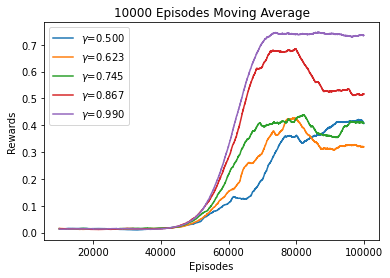

In [14]:
plot_scores_2_discount_factor()

In [40]:
def train_different_lr(env):
    lrs = [1e-5 * (10 ** i) for i in range(6)]
    scores_lr = {}
    for lr in lrs:
        print("learning rate: {:.6f}\n".format(lr), end="")
        scores_lr[lr] = q_learning_f_lake_env(env, alpha=lr)
    pickle.dump(scores_lr, open("results_fl_4/scores_lr.p", "wb"))

In [41]:
env = gym.make('FrozenLake-v1', desc=MAPS["4x4"], is_slippery=True)
train_different_lr(env)

learning rate: 0.000010
Episode 0 	Average Score: 0.00
Episode 10000 	Average Score: 0.02
Episode 20000 	Average Score: 0.01
Episode 30000 	Average Score: 0.01
Episode 40000 	Average Score: 0.01
Episode 50000 	Average Score: 0.03
Episode 60000 	Average Score: 0.05
Episode 70000 	Average Score: 0.06
Episode 80000 	Average Score: 0.06
Episode 90000 	Average Score: 0.06
Solved in: 100000 episodes and 0:00:23.172149 seconds
learning rate: 0.000100
Episode 0 	Average Score: 0.00
Episode 10000 	Average Score: 0.01
Episode 20000 	Average Score: 0.02
Episode 30000 	Average Score: 0.01
Episode 40000 	Average Score: 0.02
Episode 50000 	Average Score: 0.03
Episode 60000 	Average Score: 0.05
Episode 70000 	Average Score: 0.07
Episode 80000 	Average Score: 0.07
Episode 90000 	Average Score: 0.07
Solved in: 100000 episodes and 0:00:24.410114 seconds
learning rate: 0.001000
Episode 0 	Average Score: 0.00
Episode 10000 	Average Score: 0.02
Episode 20000 	Average Score: 0.01
Episode 30000 	Average Scor

In [42]:
def plot_scores_2_learning_rate():
    lrs = [1e-5 * (10 ** i) for i in range(6)]
    scores_lr = pickle.load(open("results_fl_4/scores_lr.p", "rb"))
    scores_lr_pd = None
    for lr in lrs:
        df = pd.DataFrame(pd.Series(list(scores_lr[lr][4])).rolling(10000).mean(),
                          columns=[r"$\alpha$=" + '{:.0e}'.format(lr)])
        scores_lr_pd = pd.concat([scores_lr_pd, df], axis=1)
    scores_lr_pd = scores_lr_pd.fillna(method='ffill')
    scores_lr_pd['Episodes'] = np.arange(scores_lr_pd.shape[0])
    ax = plt.gca()
    ax.set_title('10000 Episodes Moving Average')
    plt.ylabel("Rewards")
    scores_lr_pd.plot(kind='line', x='Episodes', y=scores_lr_pd.columns[0], ax=ax)
    scores_lr_pd.plot(kind='line', x='Episodes', y=scores_lr_pd.columns[1], ax=ax)
    scores_lr_pd.plot(kind='line', x='Episodes', y=scores_lr_pd.columns[2], ax=ax)
    scores_lr_pd.plot(kind='line', x='Episodes', y=scores_lr_pd.columns[3], ax=ax)
    scores_lr_pd.plot(kind='line', x='Episodes', y=scores_lr_pd.columns[4], ax=ax)
    scores_lr_pd.plot(kind='line', x='Episodes', y=scores_lr_pd.columns[5], ax=ax)
    plt.show()


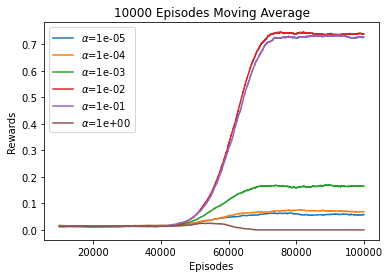

In [43]:
plot_scores_2_learning_rate()

In [197]:
def train_different_epsilon_decays(env):
    scores_epsilon_decays = {}
    epsilon_decays = [1e-02, 1e-03, 1e-04, 1e-05, 1e-06]
    for epsilon_decay in epsilon_decays:
        print("epsilon decay: {}\n".format(epsilon_decay), end="")
        scores_epsilon_decays[epsilon_decay] =  q_learning_f_lake_env(env, decay_rate=epsilon_decay)
    pickle.dump(scores_epsilon_decays, open("results_fl_4/scores_epsilon_decays.p", "wb"))

In [219]:
env = gym.make('FrozenLake-v1', desc=MAPS["4x4"], is_slippery=True)
train_different_epsilon_decays(env)

epsilon decay: 0.01
Episode 0 	Average Score: 0.00
Episode 10000 	Average Score: 0.00
Episode 20000 	Average Score: 0.00
Episode 30000 	Average Score: 0.00
Episode 40000 	Average Score: 0.00
Episode 50000 	Average Score: 0.00
Episode 60000 	Average Score: 0.00
Episode 70000 	Average Score: 0.00
Episode 80000 	Average Score: 0.05
Episode 90000 	Average Score: 0.09
Solved in: 100000.0 episodes and 0:00:35.336780 seconds
epsilon decay: 0.001
Episode 0 	Average Score: 0.00
Episode 10000 	Average Score: 0.07
Episode 20000 	Average Score: 0.07
Episode 30000 	Average Score: 0.07
Episode 40000 	Average Score: 0.11
Episode 50000 	Average Score: 0.14
Episode 60000 	Average Score: 0.16
Episode 70000 	Average Score: 0.19
Episode 80000 	Average Score: 0.23
Episode 90000 	Average Score: 0.36
Solved in: 100000.0 episodes and 0:00:37.912057 seconds
epsilon decay: 0.0001
Episode 0 	Average Score: 0.00
Episode 10000 	Average Score: 0.06
Episode 20000 	Average Score: 0.24
Episode 30000 	Average Score: 0.

In [21]:
def plot_scores_2_epsilon_decays_graph():
    epsilon_decays = [1e-02, 1e-03, 1e-04, 1e-05, 1e-06]
    scores_epsilon_decays = pickle.load(open("results_fl_4/scores_epsilon_decays.p", "rb"))
    scores_epsilon_decays_pd = None
    for epsilon_decay in epsilon_decays:
        df = pd.DataFrame(pd.Series(list(scores_epsilon_decays[epsilon_decay][4])).rolling(10000).mean(),
                          columns=["Epsilon Decay =" + str(epsilon_decay)])
        scores_epsilon_decays_pd = pd.concat([scores_epsilon_decays_pd, df], axis=1)
    scores_epsilon_decays_pd = scores_epsilon_decays_pd.fillna(method='ffill')
    scores_epsilon_decays_pd['Episodes'] = np.arange(scores_epsilon_decays_pd.shape[0])
    ax = plt.gca()
    ax.set_title('10000 Episodes Moving Average')
    plt.ylabel("Rewards")
    scores_epsilon_decays_pd.plot(kind='line', x='Episodes', y=scores_epsilon_decays_pd.columns[0], ax=ax)
    scores_epsilon_decays_pd.plot(kind='line', x='Episodes', y=scores_epsilon_decays_pd.columns[1], ax=ax)
    scores_epsilon_decays_pd.plot(kind='line', x='Episodes', y=scores_epsilon_decays_pd.columns[2], ax=ax)
    scores_epsilon_decays_pd.plot(kind='line', x='Episodes', y=scores_epsilon_decays_pd.columns[3], ax=ax)
    scores_epsilon_decays_pd.plot(kind='line', x='Episodes', y=scores_epsilon_decays_pd.columns[4], ax=ax)
    plt.show()

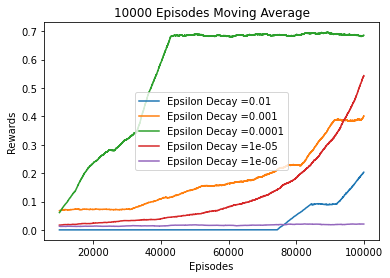

In [22]:
plot_scores_2_epsilon_decays_graph()


SFFF
FHFH
FFFH
HFFG


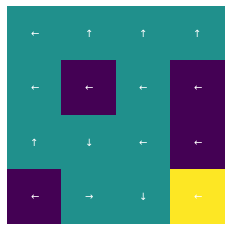

In [21]:
env = gym.make('FrozenLake-v1', desc=MAPS["4x4"], is_slippery=True)
env.render()
toolbox_env = OpenAI_MDPToolbox(env)
vi = value_iteration(toolbox_env,  gamma=0.99, eps=.001)
plot_policy(4, vi.policy)
#plot_values(vi.V, (4,4))

In [20]:
env = gym.make('FrozenLake-v1', desc=MAPS["4x4"], is_slippery=True)
env.render()
q_policy, q_solve_iter, q_solve_time, q_table, rewards = q_learning_f_lake_env(env, discount=0.99, alpha=0.1, decay_rate=1e-4)


SFFF
FHFH
FFFH
HFFG
Episode 0 	Average Score: 0.00
Episode 10000 	Average Score: 0.01
Episode 20000 	Average Score: 0.02
Episode 30000 	Average Score: 0.01
Episode 40000 	Average Score: 0.01
Episode 50000 	Average Score: 0.05
Episode 60000 	Average Score: 0.30
Episode 70000 	Average Score: 0.69
Episode 80000 	Average Score: 0.74
Episode 90000 	Average Score: 0.75
Solved in: 100000 episodes and 0:00:48.923326 seconds


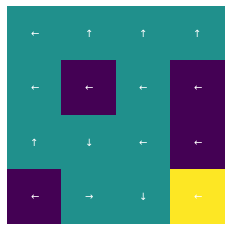

In [22]:
plot_policy(4, q_policy)

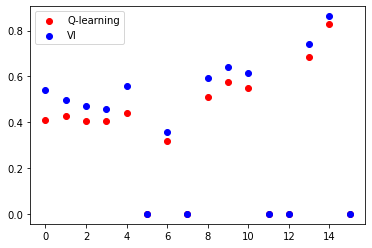

In [74]:
q_state_values =[np.max(q_table[state,:]) for state in range(q_table.shape[0])]
states = list(range(0, q_table.shape[0]))
plt.scatter(states, q_state_values, label='Q-learning', color='r', marker='o');
plt.scatter(states, vi.V, label='VI', color='b', marker='o');
plt.legend()
plt.show()

# 16x16 Frozen Lake


SFFFFFFFFFFFFFFF
HFFFFHFFFFFFFFFF
FFFHFFFHFHFFFFHF
FFFFHFHFFFFFFFHF
HHHHFFFHFFFHHFFH
FFFFHFFFFFFFHFFH
FFFFFFHFFFFHFFFF
FFFFFFFFFFHHFFFF
FFFHFHHHFFHHHFFF
FFHHFFFFFFFHFFFF
HFFFFHHFHFFFFHFF
FFHFFFFFFFFFFFFH
FFFFFFFFFFFHFFFF
HHHHFFHFFFFFFFFF
FFFFHHFFFFFHFFFH
FFFFFHFFFFFFHFFG
0.2551743984222412
0.0


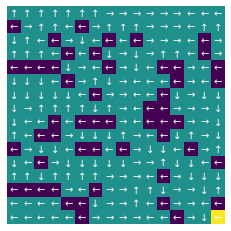

In [23]:
env = gym.make('FrozenLake-v1', desc=MAPS["16x16"], is_slippery=True)
env.render()
toolbox_env = OpenAI_MDPToolbox(env)
start = time.time()
vi = value_iteration(toolbox_env, gamma=0.99, eps=1e-15)
elapsed_time = time.time() - start
print(elapsed_time)
mean_reward, mean_eps, rewards, episode_counts = test_policy(toolbox_env.env, vi.policy, n_epoch=100)
print(mean_reward)
plot_policy(16, vi.policy)

In [68]:
mean_reward, mean_eps, rewards, episode_counts = test_policy(toolbox_env.env, vi.policy, n_epoch=1000)

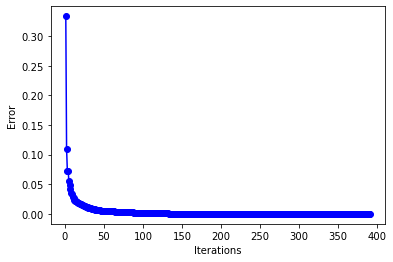

In [63]:
iterations= [stat['Iteration'] for stat in vi.run_stats]
error= [stat['Error'] for stat in vi.run_stats]
plt.plot(iterations,error, color='b', marker='o')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.show()

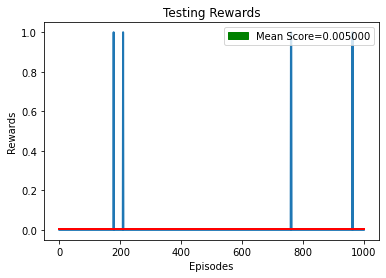

In [69]:
plot_testing_graphs(rewards)


SFFFFFFFFFFFFFFF
HFFFFHFFFFFFFFFF
FFFHFFFHFHFFFFHF
FFFFHFHFFFFFFFHF
HHHHFFFHFFFHHFFH
FFFFHFFFFFFFHFFH
FFFFFFHFFFFHFFFF
FFFFFFFFFFHHFFFF
FFFHFHHHFFHHHFFF
FFHHFFFFFFFHFFFF
HFFFFHHFHFFFFHFF
FFHFFFFFFFFFFFFH
FFFFFFFFFFFHFFFF
HHHHFFHFFFFFFFFF
FFFFHHFFFFFHFFFH
FFFFFHFFFFFFHFFG
0.1770157814025879
0.0038


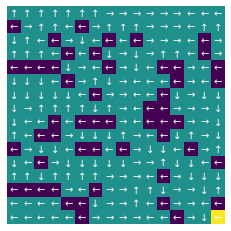

In [24]:
env = gym.make('FrozenLake-v1', desc=MAPS["16x16"], is_slippery=True)
env.render()
toolbox_env = OpenAI_MDPToolbox(env)
start = time.time()
pi = policy_iteration(toolbox_env)
elapsed_time = time.time() - start
print(elapsed_time)
mean_reward, mean_eps, rewards, episode_counts = test_policy(toolbox_env.env, pi.policy)
print(mean_reward)
plot_policy(16, pi.policy)

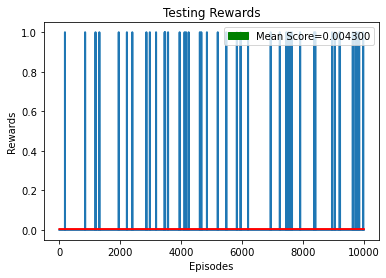

In [65]:
plot_testing_graphs(rewards)

In [76]:
env = gym.make('FrozenLake-v1', desc=MAPS["16x16"], is_slippery=True)
env.render()
q_policy, q_solve_iter, q_solve_time, q_table, rewards = q_learning_f_lake_env(env, discount=0.99, alpha=0.01, decay_rate=1e-4)


SFFFFFFFFFFFFFFF
HFFFFHFFFFFFFFFF
FFFHFFFHFHFFFFHF
FFFFHFHFFFFFFFHF
HHHHFFFHFFFHHFFH
FFFFHFFFFFFFHFFH
FFFFFFHFFFFHFFFF
FFFFFFFFFFHHFFFF
FFFHFHHHFFHHHFFF
FFHHFFFFFFFHFFFF
HFFFFHHFHFFFFHFF
FFHFFFFFFFFFFFFH
FFFFFFFFFFFHFFFF
HHHHFFHFFFFFFFFF
FFFFHHFFFFFHFFFH
FFFFFHFFFFFFHFFG
Episode 0 	Average Score: 0.00
Episode 10000 	Average Score: 0.00
Episode 20000 	Average Score: 0.00
Episode 30000 	Average Score: 0.00
Episode 40000 	Average Score: 0.00
Episode 50000 	Average Score: 0.00
Episode 60000 	Average Score: 0.00
Episode 70000 	Average Score: 0.00
Episode 80000 	Average Score: 0.00
Episode 90000 	Average Score: 0.00
Solved in: 100000 episodes and 0:00:10.187161 seconds


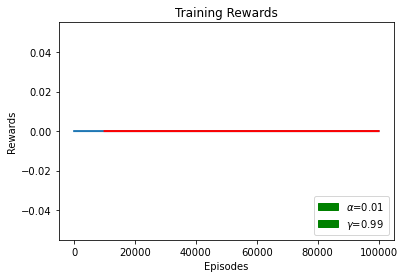

In [302]:
plot_training_graphs(rewards,discount=0.99, alpha=0.01)

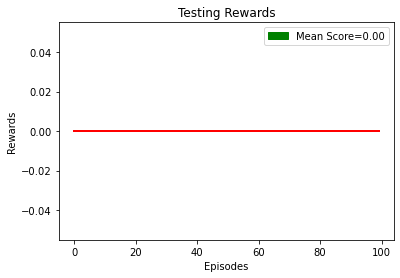

In [303]:
mean_reward, mean_eps, test_rewards, episode_counts = test_policy(env , q_policy, n_epoch=100)
plot_testing_graphs(test_rewards)

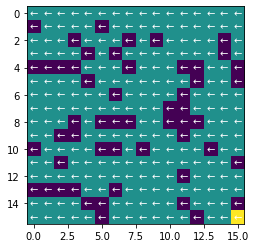

In [304]:
plot_policy(16, q_policy)

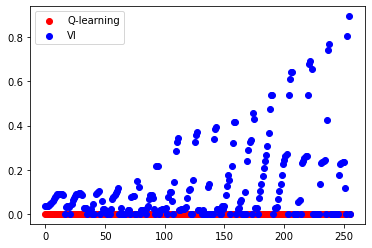

In [78]:
q_state_values =[np.max(q_table[state,:]) for state in range(q_table.shape[0])]
states = list(range(0, q_table.shape[0]))
plt.scatter(states, q_state_values, label='Q-learning', color='r', marker='o');
plt.scatter(states, vi.V, label='VI', color='b', marker='o');
plt.legend()
plt.show()

In [19]:
env = gym.make('FrozenLake-v1', desc=MAPS["16x16"], is_slippery=True)
actions= int(re.findall(r'\d+', str(env.action_space))[0])
states= int(re.findall(r'\d+', str(env.observation_space))[0])
for state in range(states):
    for action in range(actions):
        possible_actions = env.P[state][action]
        for i in range(len(possible_actions)):
            if possible_actions[i][3]== True and possible_actions[i][1]!=255:
                y = list(possible_actions[i])
                #print(y)
                y[2] = -1.0
                x = tuple(y)
                #print(x)
                env.P[state][action][i] = x
            if possible_actions[i][3]== True and possible_actions[i][1]==255 and state!=255:
                y = list(possible_actions[i])
                #print(y)
                y[2] = 2.0
                x = tuple(y)
                #print(x)
                env.P[state][action][i] = x
            
env.render() 


SFFFFFFFFFFFFFFF
HFFFFHFFFFFFFFFF
FFFHFFFHFHFFFFHF
FFFFHFHFFFFFFFHF
HHHHFFFHFFFHHFFH
FFFFHFFFFFFFHFFH
FFFFFFHFFFFHFFFF
FFFFFFFFFFHHFFFF
FFFHFHHHFFHHHFFF
FFHHFFFFFFFHFFFF
HFFFFHHFHFFFFHFF
FFHFFFFFFFFFFFFH
FFFFFFFFFFFHFFFF
HHHHFFHFFFFFFFFF
FFFFHHFFFFFHFFFH
FFFFFHFFFFFFHFFG


0.0


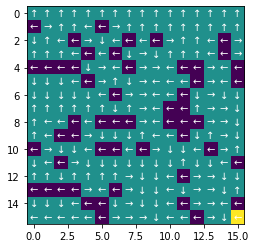

In [83]:
toolbox_env = OpenAI_MDPToolbox(env)
vi = value_iteration(toolbox_env, gamma=0.99, eps=.001)
mean_reward, mean_eps, rewards, episode_counts = test_policy(toolbox_env.env, vi.policy)
print(mean_reward)
plot_policy(16, vi.policy)

In [25]:
q_policy, q_solve_iter, q_solve_time, q_table, rewards = q_learning_f_lake_env(env, discount=0.99, alpha=0.01, decay_rate=1e-4)

Episode 0 	Average Score: -1.00
Episode 10000 	Average Score: -1.00
Episode 20000 	Average Score: -1.00
Episode 30000 	Average Score: -1.00
Episode 40000 	Average Score: -1.00
Episode 50000 	Average Score: -1.00
Episode 60000 	Average Score: -0.70
Episode 70000 	Average Score: -0.06
Episode 80000 	Average Score: 0.00
Episode 90000 	Average Score: 0.00
Solved in: 100000 episodes and 98.52874779701233 seconds


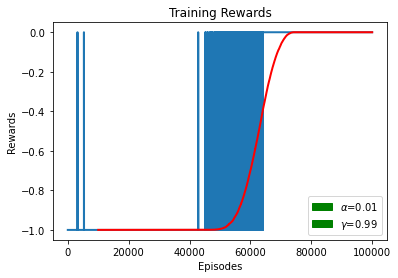

In [26]:
#rewards = [x / 2.0 for x in rewards]
plot_training_graphs(rewards,discount=0.99, alpha=0.01)

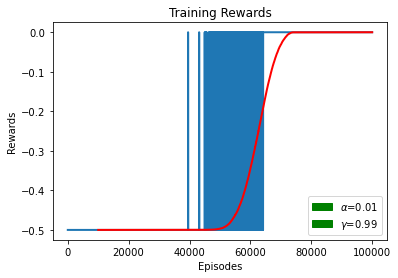

In [307]:
rewards = [x / 2.0 for x in rewards]
plot_training_graphs(rewards,discount=0.99, alpha=0.01)

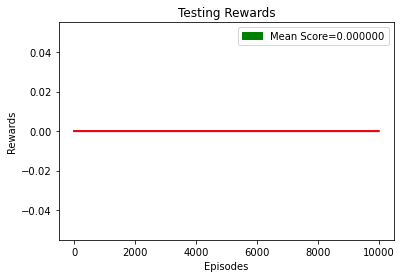

In [28]:
env = gym.make('FrozenLake-v1', desc=MAPS["16x16"], is_slippery=True)
mean_reward, mean_eps, test_rewards, episode_counts = test_policy(env , q_policy, n_epoch=10000)
plot_testing_graphs(test_rewards)

0.0


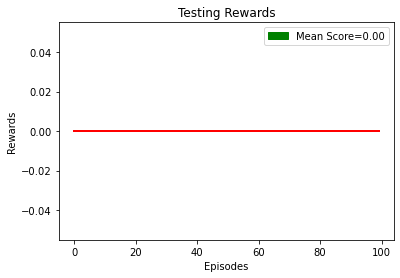

In [308]:
mean_reward, mean_eps, test_rewards, episode_counts = test_policy(env , q_policy, n_epoch=100)
print(mean_reward)
test_rewards = [x / 2.0 for x in test_rewards]
plot_testing_graphs(test_rewards)

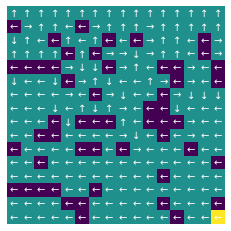

In [29]:
plot_policy(16, q_policy)

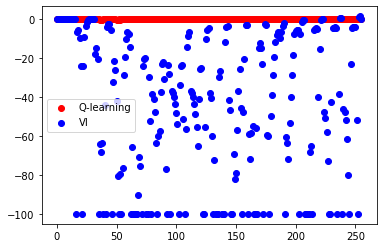

In [84]:
q_state_values =[np.max(q_table[state,:]) for state in range(q_table.shape[0])]
states = list(range(0, q_table.shape[0]))
plt.scatter(states, q_state_values, label='Q-learning', color='r', marker='o');
plt.scatter(states, vi.V, label='VI', color='b', marker='o');
plt.legend()
plt.show()

In [31]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
